# Pipeline for Ca-Data-Preprocessing

In [1]:
# import libraries
from skimage import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyQt5.QtWidgets import QFileDialog, QApplication
import cv2 as cv
from skimage.feature import peak_local_max
from skimage.segmentation import clear_border,watershed
from skimage.morphology import remove_small_objects
from skimage.filters import threshold_local
from skimage.registration import phase_cross_correlation
from scipy import ndimage as ndi
from scipy import signal
from copy import copy

dir = os.getcwd()
app = QApplication([dir])

In [2]:
# function for motion correction (registration) of calcium frames (tiff-stack)
def registration(raw_frames, binsize=500, stepsize=250):
    if binsize is not None:
        binsize = binsize
    if stepsize is not None:
        stepsize = stepsize
    image_template = np.mean(raw_frames[:binsize], axis=0)
    i = stepsize
    regTifImg = copy(raw_frames)
    old_drift = None
    while i < raw_frames.shape[0]:
        moving_template = np.mean(raw_frames[i:i + binsize], axis=0)
        image_drift = phase_cross_correlation(image_template, moving_template)[0]
        if old_drift is None:
            old_drift = image_drift
        for o in range(min(stepsize, raw_frames.shape[0] - i)):
            itershift = np.vstack(
                [np.eye(2), image_drift[::-1] * (1 - o / stepsize) + old_drift[::-1] * o / stepsize]).T
            regTifImg[i + o] = cv.warpAffine(raw_frames[i + o], itershift, tuple(image_template.shape))
        old_drift = image_drift
        i += stepsize
    reg_frames = regTifImg
    std_image = np.std(reg_frames, axis=0)
    fig_name = 'Registration_STD_image'
    fig, ax = plt.subplots(1, 2, figsize=(16,8), num=fig_name)
    ax[0].set_title('Raw STD image')
    ax[0].imshow(np.std(raw_frames, axis=0))
    ax[1].set_title('Registered STD image')
    ax[1].imshow(std_image)
    fig.tight_layout()
    plt.show()   
    return reg_frames, std_image

rnorm = lambda x: (x-x.min())/(x.max()-x.min())

# function for cell segmentation based on watershed algorithm
def cell_segmentation(std_image, segmentation_params_arg=None):
    
    segmentation_params = {
    'hpfiltSig': .1,
    'localThreKerSize': 25,
    'smoothSig': 3,
    'binaryThre': .5,
    'minSizeLim': 50,
    'maxSizeLim': 500,
    'bgKerSize': 2,
    'fgKerSize': 1    
    }
    
    if segmentation_params_arg is not None:
        segmentation_params.update(segmentation_params_arg)
    
    #image smoothing
    hpRaw = cv.GaussianBlur(std_image,(0,0),segmentation_params['hpfiltSig'])
    bpRaw = hpRaw/threshold_local(hpRaw,segmentation_params['localThreKerSize'])
    smoothed_std_image = cv.GaussianBlur(rnorm(bpRaw), (0, 0), segmentation_params['smoothSig'])
    # fig_name = 'Image Smoothing'
    # fig = plt.figure(figsize=(16,8), num=fig_name)
    # plt.title('Smoothed STD image')
    # plt.imshow(smoothed_std_image)
    # fig.tight_layout()
    # plt.show()   
    
    #image binarization
    bwIm = (smoothed_std_image>(np.mean(smoothed_std_image)+segmentation_params['binaryThre']*np.std(smoothed_std_image)))
    binarized_std_image = remove_small_objects(bwIm, segmentation_params['minSizeLim'], connectivity=4).astype(np.uint8)
    # fig_name = 'Image Binarization'
    # fig = plt.figure(figsize=(16,8), num=fig_name)
    # plt.title('Binarized STD image')
    # plt.imshow(binarized_std_image)
    # fig.tight_layout()
    # plt.show() 
    
    #compute bgMarker and fgMarker
    bgDilateKer = np.ones((segmentation_params['bgKerSize'],)*2,np.uint8)
    bgMarker = clear_border(cv.dilate(binarized_std_image, bgDilateKer, 1)>0)
    conn = np.ones((3,3,))
    fgDilateKer = np.ones((segmentation_params['fgKerSize'],)*2,np.uint8)
    maxCoord = peak_local_max(smoothed_std_image, footprint=conn, indices=False, exclude_border=0)
    fgMarker = clear_border(cv.dilate(maxCoord.astype(np.uint8), fgDilateKer)) > 0
    
    #watershed
    distanceMap = ndi.distance_transform_edt(bgMarker)
    markers = ndi.label(fgMarker)[0]
    raw_labels = watershed(-distanceMap,markers,mask=bgMarker,watershed_line=True)

    #filter ROIs by size
    temp_val, temp_idx = np.unique(raw_labels, return_inverse=True)
    num_of_val = np.bincount(temp_idx)
    exclude_val = temp_val[np.bitwise_or(num_of_val <= np.array(segmentation_params['minSizeLim']), num_of_val >= np.array(segmentation_params['maxSizeLim']))]
    labels = copy(raw_labels)
    labels[np.isin(raw_labels, exclude_val)] = 0
    
    #order labels
    sorted_labels = copy(labels)
    for i,v in enumerate(np.unique(labels)):
        sorted_labels[labels == v] = i
    
    roi_mask = sorted_labels
    
    fig_name = 'sizeFilter'
    fig = plt.figure(figsize=(16,8), num=fig_name)
    plt.title('ROI Map')
    plt.imshow(std_image/40+40*np.squeeze(np.abs(np.gradient(sorted_labels)).sum(axis=0)>0))
    fig.tight_layout()
    plt.show()   
    
    return roi_mask
    

# function to extract single calcium traces based on segmented ROI mask
def extract_calcium_signals(roi_mask, reg_frames, display_traces=True):
    raw_ca_traces = []
    for i in np.unique(roi_mask):
        if i > 0:
            raw_ca_traces.append(reg_frames[:,roi_mask==i].sum(axis=1))
    
    if display_traces:
       fig_name = 'Calcium Traces'
       fig = plt.figure(figsize=(16,8), num=fig_name)
       plt.title('Raster Plot ROIs')
       plt.imshow(np.array(raw_ca_traces))
       plt.xlabel('frames')
       plt.ylabel('ROIs')
       fig.tight_layout()
       plt.show()       
    return raw_ca_traces

# function to calculate dff
def calc_dff(raw_ca_traces, num_frames_avg=25, display_traces=True):
    dff_ca_traces = []
    for i in range(len(raw_ca_traces)):
        sorted_trace = np.sort(raw_ca_traces[i])
        dff_ca_traces.append((raw_ca_traces[i] - np.mean(sorted_trace[1:num_frames_avg])) / np.mean(sorted_trace[1:num_frames_avg]))          
    if display_traces:
        fig_name = 'DFF Calcium Traces'
        fig = plt.figure(figsize=(16, 8), num=fig_name)
        plt.title('Raster Plot ROIs DFF')
        plt.imshow(np.array(dff_ca_traces))
        plt.xlabel('frames')
        plt.ylabel('ROIs')
        fig.tight_layout()
        plt.show()       
    return dff_ca_traces

In [3]:
# select files with calcium data

filename_ca_data = QFileDialog.getOpenFileName(None,"Select Calcium Recording...",filter="Files(*.tif)")
raw_frames = np.array(io.imread(filename_ca_data[0]))

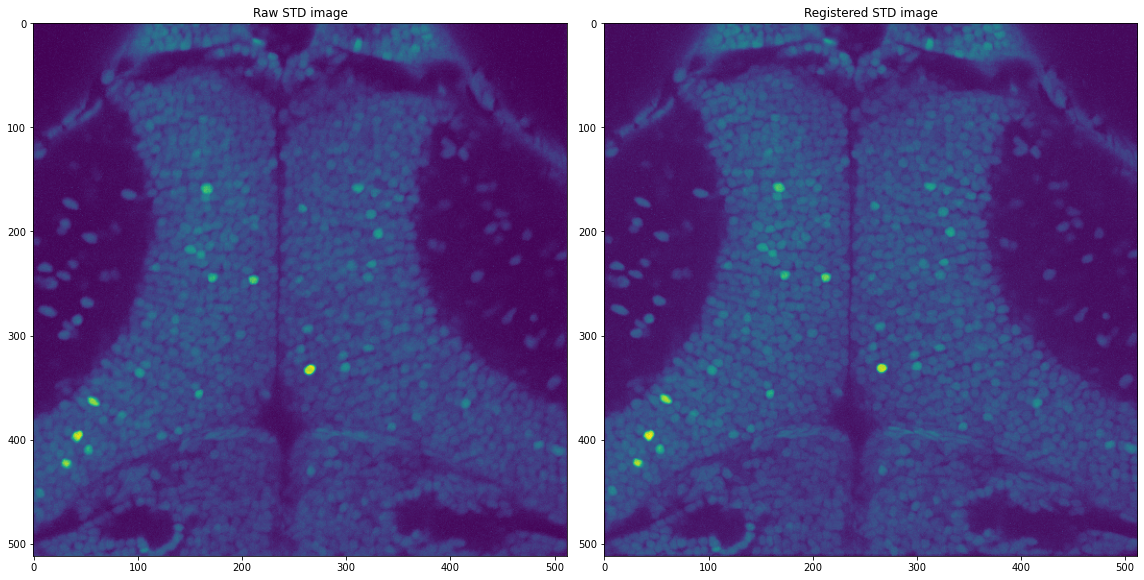

In [4]:
# registration (motion correction) of calcium frames and computation of STD image

reg_frames, std_image = registration(raw_frames, binsize=60, stepsize=40)    #10, 10

C:\Users\dburkhardt\AppData\Local\Temp\ipykernel_16468\3776613098.py:79: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  maxCoord = peak_local_max(smoothed_std_image, footprint=conn, indices=False, exclude_border=0)


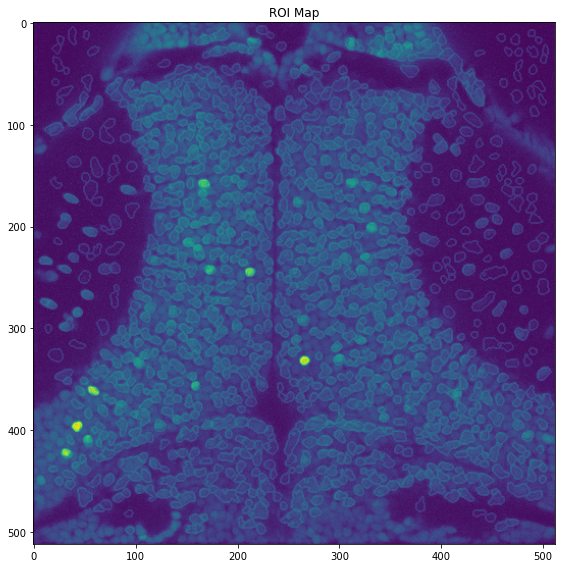

In [5]:
# cell (ROIs) segmentation with watershed algorithm
segmentation_params = {
    'hpfiltSig': .1,
    'localThreKerSize': 9,
    'smoothSig': 3,
    'binaryThre': .5,
    'minSizeLim': 20,
    'maxSizeLim': 500,
    'bgKerSize': 2,
    'fgKerSize': 1
    }
roi_mask = cell_segmentation(std_image, segmentation_params)

In [6]:
# extract calcium traces for ROIs

raw_ca_traces = extract_calcium_signals(roi_mask, reg_frames, display_traces=False)

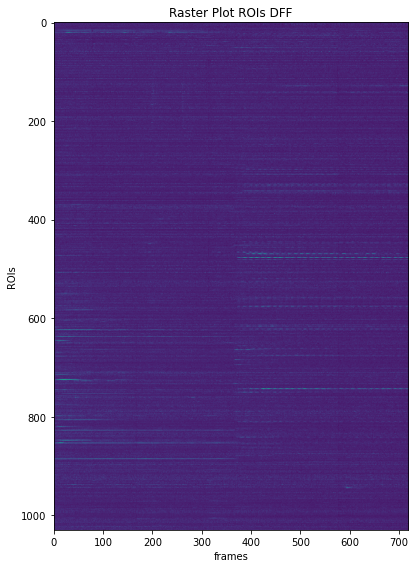

In [7]:
# calc dff

dff_ca_traces = calc_dff(raw_ca_traces, num_frames_avg=25, display_traces=True)